# Introduction
This is a notebook for food object detection for Hedia <br>
The notebook follows the structure from the pytorch example notebook found [here](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#defining-the-dataset).

## Dependencies

First dependencies need to be installed, here cython and pycocotools are needed

In [ ]:
# mount drive, this should be set to the folder where the data folder is stored
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/My Drive/DTU/Deep learning/FoodRecognition'

/content/drive/My Drive/DTU/Deep learning/FoodRecognition


In [ ]:
%%shell

#own repository with utils
if [ -d FoodRecognition ]
then 
  cd FoodRecognition
  git pull 
  cd ..
else
  git clone https://github.com/s183920/FoodRecognition.git
fi

# copy functions to make available
cp FoodRecognition/Colab_utils/setup.sh .
# cp FoodRecognition/Colab_utils/dataloader.py .
# cp FoodRecognition/Colab_utils/model.py .

# install dependencies
install_cython=1
install_coco=1
sh FoodRecognition/Colab_utils/setup.sh $install_cython $install_coco

remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 6 (delta 4), reused 6 (delta 4), pack-reused 0
Unpacking objects: 100% (6/6), done.
From https://github.com/s183920/FoodRecognition
   7940deb..addbe34  main       -> origin/main
Updating 7940deb..addbe34
Fast-forward
 Colab_utils/setup.sh | 11 +++++++++++
 1 file changed, 11 insertions(+)
cython will not be installed
pycocotools will not be installed!
torchvision repo already installed


# Data and structure

Original data can be found [here](https://drive.google.com/file/d/1hz5AxTTVcfQz1dK0uoyfE89fMrZXQEzk/view)

A version of the VOC2007 directory with all files can be found [here](https://drive.google.com/file/d/1xQ3PmHLRKbhgcpF2D2dv0xNr1bjIFaCB/view) if needed

Data should be stored in a folder called data with the structure
```
data/
  VOC/
    VOCdevkit/
      VOC2007/
        Annotations/
          000001.xml
          000002.xml
          000003.xml
          ...
        ImageSets/
          Main/
            test.txt
            train.txt
            trainval.txt
            val.txt
            boiled peas_test.txt
            ...
        JPEGimages/
          000001.jpg
          000002.jpg
          000003.jpg
          ...
        ...other files
      VOCcode/
      ...other files

```
<p>
<span style="color:blue"> OBS: Errors in the class name of the following Annotation files should be corrected </span>
</p>

```
000656.xml
```

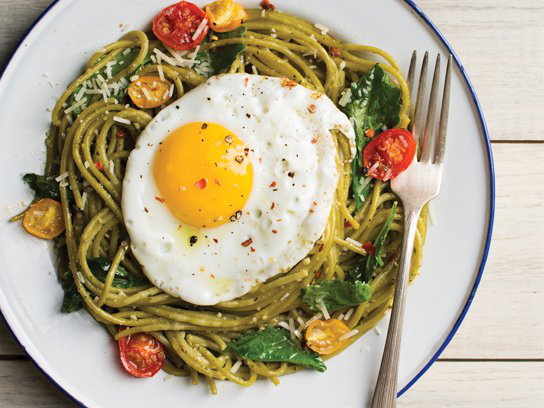

In [ ]:
# example image
from PIL import Image, ImageDraw
data_path = "data/VOC/VOCdevkit/VOC2007/"
f = "000013" 
im = Image.open(data_path + f"JPEGImages/{f}.jpg")
im

## Data loader function



In [ ]:
"""
Load data into a dataset class that can be used to train our model.
"""

import torchvision.datasets as datasets
import numpy as np
import torch
import torchvision.transforms as transforms
import os

# dicts for converting classes to labels
classes = ['__background__', 'boiled peas', 'boiled potatoes', 'chopped lettuce', 'fried egg',
        'glass of milk', 'glass of water', 'meatballs', 'plain rice', 'plain spaghetti',
        'slice of bread']

cls_to_label_dict = {j:i for i,j in enumerate(classes)}
label_to_cls_dict = {i:j for i,j in enumerate(classes)}

class foodDataset(torch.utils.data.Dataset):
    """
    Class to store the food data
    """
    def __init__(self, data_root:str, datatype:str = "train", transforms = None):
      self.data_root = data_root
      self.transforms = transforms
      self.splitImgPath = data_root + "VOCdevkit/VOC2007/ImageSets/Main/" + datatype + ".txt"
      with open(self.splitImgPath, "r") as splitIdx:
        self.imgNames = splitIdx.readlines()

      # self.dataset = datasets.VOCDetection(data_root, year='2007', image_set = datatype, transform=self.transforms)
      self.dataset = datasets.VOCDetection(data_root, year='2007', image_set = datatype)

    def __getitem__(self, idx):
      img = self.dataset[idx][0]
      obs = self.dataset[idx][1]["annotation"]["object"]
      num_objs = len(obs)

      image_id = torch.tensor([int(os.path.splitext(self.dataset[idx][1]["annotation"]["filename"])[0])])

      boxes = []
      labels = torch.ones((num_objs,), dtype=torch.int64)
      for i in range(num_objs):
        xmin = int(obs[i]["bndbox"]["xmin"])
        xmax = int(obs[i]["bndbox"]["xmax"])
        ymin = int(obs[i]["bndbox"]["ymin"])
        ymax = int(obs[i]["bndbox"]["ymax"])
        boxes.append([xmin, ymin, xmax, ymax])
        cls = obs[i]["name"]
        try:
          labels[i] *= cls_to_label_dict[cls]
        except KeyError:
          raise KeyError(f"Image {image_id} had an unavailable label: {cls} ")
      boxes = torch.as_tensor(boxes, dtype=torch.float32)

      area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

      # suppose all instances are not crowd
      iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
      
      target = {}
      target["boxes"] = boxes
      target["labels"] = labels
      target["area"] = area
      target["image_id"] = image_id
      target["iscrowd"] = iscrowd

      return (img, target) if self.transforms is None else self.transforms(img, target)

    def __len__(self):
      return len(self.imgNames)

In [ ]:
root = "data/VOC/"
data = foodDataset(root, "train", transforms = None)
data[1]

(<PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD919DAD7F0>,
 {'area': tensor([126773.]),
  'boxes': tensor([[173., 131., 556., 462.]]),
  'image_id': tensor([326]),
  'iscrowd': tensor([0]),
  'labels': tensor([4])})

# Model

Here a pretrained resnet50 is used




In [ ]:
# from model import get_model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
classes = ['__background__', 'boiled peas', 'boiled potatoes', 'chopped lettuce', 'fried egg',
        'glass of milk', 'glass of water', 'meatballs', 'plain rice', 'plain spaghetti',
        'slice of bread']
def get_model(pretrained:bool = True): 
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)
    
    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = len(classes)  # 9 classes  + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"Device used is: {device}")
    model.to(device)

    return model
model = get_model()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth



Device used is: cuda


# Training

## Data loader with transforms

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)
    
# use our dataset and defined transformations
root = "data/VOC/"
dataset = foodDataset(root, "train", get_transform(train=True))
dataset_test = foodDataset(root, "test", get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
#!pip install GPyOpt
#import numpy as np
#import GPyOpt
#import random
#import time
#import pickle
#import matplotlib.pyplot as plt
#import torch
#optparams = pickle.load(open("Kopi af opt_params_best.pkl", "rb"))

## Train function


In [ ]:

import pickle
def train(model_name = "model", start_epoch = 0, num_epochs = 40, use_existing = False,
          optimiser = "SGD", lr = 0.0079, weight_decay = 1e-05, eval = True):
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  print(f"Device used is: {device}")
  model = torch.load(f"models/{model_name}_epoch{start_epoch}.pth") if use_existing  else get_model()
  model.to(device)

  # construct an optimizer
  params = [p for p in model.parameters() if p.requires_grad]
  if optimiser is "SGD":
    optimizer = torch.optim.SGD(params, lr=lr,
                              momentum=0.9, weight_decay=weight_decay) 
  elif optimiser is "Adam":
    optimizer = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
  else:
    raise ValueError(f"The given optimiser \"{optimiser}\" was not an option")

  # and a learning rate scheduler which decreases the learning rate by
  # 10x every 3 epochs
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                              step_size=3,
                                              gamma=0.1)

  # training loop
  for epoch in range(start_epoch, start_epoch+num_epochs):
      # train for one epoch, printing every 10 iterations
      logger, loss = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
      
      #fname = f"logs/{model_name}_logger_epoch{epoch+1}.pkl"
      #with open(f"logs/{model_name}_logger_epoch{epoch+1}.pkl", "wb") as f:
      #  pickle.dump(logger, f)
      
      pickle_file = open(str(epoch) + "_losses2.pickle", "wb")
      pickle.dump(logger.meters, pickle_file)

      torch.save(model, f"models/{model_name}_epoch{epoch+1}.pth")
      # update the learning rate
      lr_scheduler.step()
      # evaluate on the test dataset
      if eval:
        evaluate(model, data_loader_test, device=device)
  
  loss_dict = {"loss" : logger.meters["loss"]}
  return loss_dict

# train()
# while True:pass
    

Streaming output truncated to the last 5000 lines.
Epoch: [2]  [ 160/1054]  eta: 0:10:04  lr: 0.007900  loss: 0.3418 (0.3432)  loss_classifier: 0.1754 (0.1681)  loss_box_reg: 0.1624 (0.1501)  loss_objectness: 0.0098 (0.0126)  loss_rpn_box_reg: 0.0095 (0.0124)  time: 0.6684  data: 0.0070  max mem: 4573
Epoch: [2]  [ 170/1054]  eta: 0:09:53  lr: 0.007900  loss: 0.3047 (0.3425)  loss_classifier: 0.1556 (0.1681)  loss_box_reg: 0.1439 (0.1495)  loss_objectness: 0.0123 (0.0127)  loss_rpn_box_reg: 0.0079 (0.0122)  time: 0.6375  data: 0.0078  max mem: 4573
Epoch: [2]  [ 180/1054]  eta: 0:09:41  lr: 0.007900  loss: 0.2393 (0.3422)  loss_classifier: 0.1026 (0.1671)  loss_box_reg: 0.0984 (0.1496)  loss_objectness: 0.0123 (0.0131)  loss_rpn_box_reg: 0.0074 (0.0124)  time: 0.5814  data: 0.0072  max mem: 4573
Epoch: [2]  [ 190/1054]  eta: 0:09:33  lr: 0.007900  loss: 0.2352 (0.3426)  loss_classifier: 0.1242 (0.1673)  loss_box_reg: 0.0984 (0.1501)  loss_objectness: 0.0072 (0.0129)  loss_rpn_box_reg: 

{'loss': <utils.SmoothedValue at 0x7fd8c9ecf470>}

## Bayesian optimisation



### Objective function

In [ ]:
def objective_function(x):
  num_epochs = 2

  params = x[0] 

  # learning rate
  learning_rate = params[0]
  optimiser = "SGD" if params[1] == 0 else "Adam"
  wd = params[2]

  model_name = f"BO/model_{learning_rate}_{optimiser}_{wd}"

  # train model
  print("-"*30)
  print("Training started with parameters: learning rate: " + str(learning_rate) + 
  ", optimizer: " + optimiser + ", weight decay: "+ str(wd))
  train(model_name = model_name, start_epoch = 0, num_epochs = num_epochs, use_existing = False,
        optimiser = optimiser, lr = learning_rate, weight_decay = wd, eval = False)

  # test model
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model = torch.load(f"models/{model_name}_epoch{num_epochs}.pth")
  eval = evaluate(model, data_loader_test, device=device)
  
  return -eval.coco_eval["bbox"].stats[0]


### Finding the best parameters

In [ ]:
# !python -m pip install GPyOpt
import numpy as np
import GPyOpt
import random
import time
import pickle
import matplotlib.pyplot as plt
import torch


# set seed
seed = 4200
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

# learning rate
learning_rate = tuple(np.arange(0.0001,0.011 ,0.0001, dtype= np.float))

# weight decay
weight_decay = tuple(np.arange(1e-5, 1e-3, 1e-5))


#optimizer (SGD, Adam)
optimizer_dict = {0: "SGD", 1: "Adam"}
optimizer = (0, 1)


# define the dictionary for GPyOpt

domain = [{'name': 'learning_rate', 'type': 'discrete', 'domain': learning_rate},
            {'name': 'optimizer', 'type': 'categorical', 'domain': optimizer},
            {'name': 'weight_decay', 'type': 'discrete', 'domain': weight_decay}]


#optimization
opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = 'EI'      # Select acquisition function MPI, EI, LCB
                                             )


opt.acquisition.exploration_weight = 3

t_opt = time.time()
opt.run_optimization(max_iter = 20) 
print("-"*30)
print("Optimization finished!")
print(f"Time used for optimization: {time.time()-t_opt} seconds")

x_best = opt.X[np.argmin(opt.Y)]
print(f"Best loss was obtained at {opt.fx_opt*-1} %")
print("The best parameters obtained: learning rate=" + str(x_best[0]) + ", optimizer=" + str(optimizer_dict[x_best[1]]) + ", weight decay=" + str(x_best[2]))

# save 
#with open("models/BO/opt_params.pkl", "wb") as f:
#    pickle.dump(opt, f)

#with open("models/BO/opt_params_best.pkl", "rb") as f:
#    best_opt = pickle.load(f)

#if opt.fx_opt*-1 > best_opt.fx_opt*-1:
#    with open("models/BO/opt_params_best.pkl", "wb") as f:
#        pickle.dump(opt, f)

pickle_file = open("BO.pickle", "wb")
pickle.dump(x_best, pickle_file)


# plots
# GPyOpt.plotting.plots_bo.plot_acquisition(opt)
GPyOpt.plotting.plots_bo.plot_convergence(opt.X, opt.Y*-1)
plt.show()

In [ ]:
#import pickle
#saved_BO = pickle.load(open("BO.pickle", "rb"))
#saved_BO
# best hyperparams: The best parameters obtained: learning rate=0.0079, optimizer=SGD, weight decay=5e-05

## Training with BO parameters

In [ ]:
#with open("models/BO/opt_params_best.pkl", "rb") as f:
#    best_opt = pickle.load(f)

#x_best = best_opt.X[np.argmin(opt.Y)]
#num_epochs = 20

#train(model_name = f"model_BO", start_epoch = 0, num_epochs = num_epochs, use_existing = False,
#        optimiser = x_best[1], lr = x_best[0], weight_decay = x_best[2])

# while True:pass

## Plot loss function

Text(0, 0.5, 'loss')

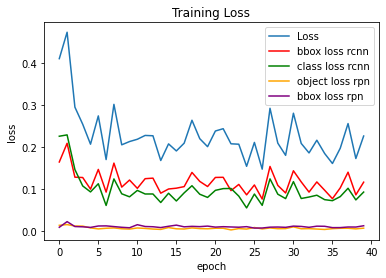

In [ ]:
import matplotlib.pyplot as plt
import pickle
# Loading pickles
start_epoch = 0
num_epochs = 40
loss_list = []
for epoch in range(start_epoch, start_epoch+num_epochs):
    saved_losses = pickle.load(open(str(epoch)+"_losses2.pickle", "rb"))
    loss_list.append(saved_losses)

## Loss plot
losses_avg = []
loss_box_reg_rcnn = [] 
loss_box_class_rcnn = []
loss_box_object_rpn = []
loss_box_rpn = []
for i in range(len(loss_list)):
    losses_avg.append(loss_list[i]['loss'].avg)

for i in range(len(loss_list)):
    loss_box_reg_rcnn.append(loss_list[i]['loss_box_reg'].avg)

for i in range(len(loss_list)):
    loss_box_class_rcnn.append(loss_list[i]['loss_classifier'].avg)

for i in range(len(loss_list)):
    loss_box_object_rpn.append(loss_list[i]['loss_objectness'].avg)

for i in range(len(loss_list)):
    loss_box_rpn.append(loss_list[i]['loss_rpn_box_reg'].avg)


plt.plot(losses_avg, label = 'Loss')
plt.plot(loss_box_reg_rcnn, color = 'red', label = 'bbox loss rcnn')
plt.plot(loss_box_class_rcnn, color = 'green', label = 'class loss rcnn')
plt.plot(loss_box_object_rpn, color = 'orange', label = 'object loss rpn')
plt.plot(loss_box_rpn, color = 'purple', label = 'bbox loss rpn')
plt.legend()
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
